# CE ARR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## Data Pre-processing

In [2]:
df_train = pd.read_csv('../train_data.nosync/train_data.csv', header=None)
df_val = pd.read_csv('./val_data.csv', header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,-0.265,-0.265,-0.290,-0.310,-0.325,-0.315,-0.295,-0.280,-0.285,-0.280,...,-0.170,-0.145,-0.155,-0.170,-0.180,-0.185,-0.190,-0.19,-0.200,0.0
1,-0.110,-0.110,-0.105,-0.095,-0.080,-0.050,-0.050,-0.050,-0.050,-0.040,...,-0.315,-0.285,-0.275,-0.265,-0.260,-0.275,-0.290,-0.28,-0.275,12.0
2,-0.380,-0.380,-0.400,-0.415,-0.395,-0.380,-0.380,-0.395,-0.390,-0.415,...,-0.390,-0.410,-0.445,-0.435,-0.420,-0.415,-0.400,-0.41,-0.425,0.0
3,-0.955,-0.945,-0.960,-0.960,-0.970,-0.970,-0.955,-0.935,-0.940,-0.920,...,-0.995,-1.000,-1.010,-1.040,-1.040,-1.025,-1.020,-1.00,-0.990,0.0
4,0.030,0.030,0.055,0.060,0.040,0.030,0.035,0.040,0.060,0.050,...,-0.010,0.000,-0.005,-0.025,-0.015,-0.020,-0.015,0.01,0.005,0.0


In [3]:
df_train.shape

(65670, 251)

In [4]:
# Split the training data into feature and target
X_train = df_train.iloc[:,:-1].values
y_train = df_train.iloc[:,-1:].values.ravel()
X_val = df_val.iloc[:,:-1].values
y_val = df_val.iloc[:,-1:].values.ravel()

## Fourier Attempt

In [5]:
time = np.arange(0, 250)
fx_train = df_train.iloc[:,:-1].values
fy_train = df_train.iloc[:,-1:].values.ravel()
fx_val = df_val.iloc[:,:-1].values
fy_val = df_val.iloc[:,-1:].values.ravel()

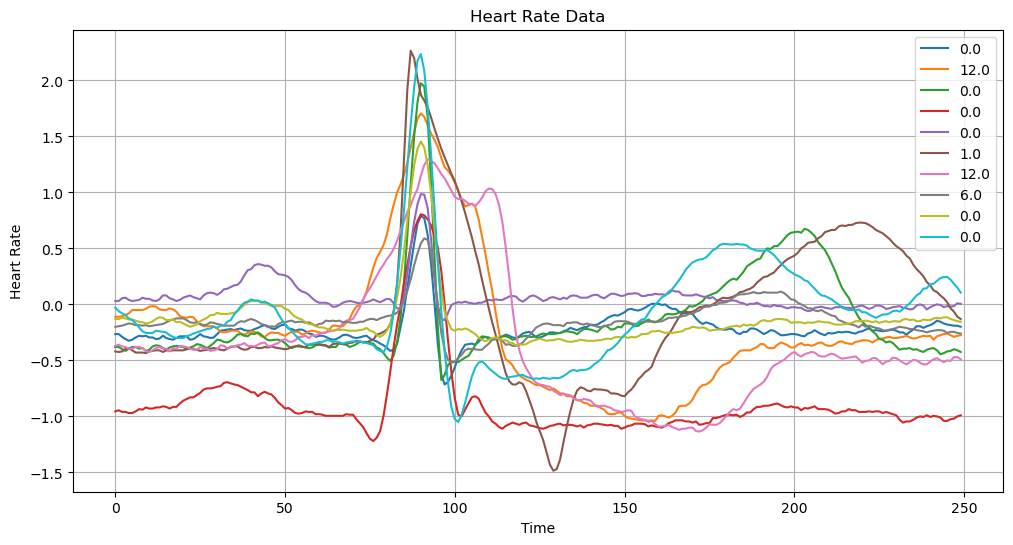

In [6]:
plt.figure(figsize=(12, 6))

cnt = 10
for beat in fx_train[:cnt]:
    plt.plot(beat)

plt.legend(y_train[:cnt])
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate Data')
plt.grid()
plt.show()

In [26]:
# Parameter to determine frequency breadth of the FFT data as percentage of spectrum
total_breadth = len(fx_train[0])
perc =.3

breadth = (perc*total_breadth)
breadth = int(breadth)
breadth

75

In [27]:
# Calculate FFT's for the Train Set
# Number (count) of beats to apply transform too and arrays for data
cnt = len(fx_train)
fx_train_mags = []
fx_train_magsdb = []
fx_train_freqs = []


for beat in fx_train[:cnt]:
    # Calculate the FFT
    fft_result = np.fft.fft(beat)

    # Calculate freq values corresponding with the FFT result
    freq = np.fft.fftfreq(len(time))

    # Eliminate negative frequencies
    pos_freqs = freq > 0
    fft_result = fft_result[pos_freqs]
    freq = freq[pos_freqs]

    # Calculate magnitude of the FFT result
    mag = np.abs(fft_result)
    mag_db = 20 * np.log10(mag)
    
    fx_train_mags.append(mag[0:breadth]) 
    fx_train_magsdb.append(mag_db[0:breadth]) 
    fx_train_freqs.append(freq[0:breadth])

In [28]:
# Calculate FFT's for the Validation Set
cnt = len(fx_val)
fx_val_mags = []
fx_val_magsdb = []
fx_val_freqs = []

for beat in fx_val[:cnt]:
    # Calculate the FFT
    fft_result = np.fft.fft(beat)

    # Calculate freq values corresponding with the FFT result
    freq = np.fft.fftfreq(len(time))

    # Eliminate negative frequencies
    pos_freqs = freq > 0
    fft_result = fft_result[pos_freqs]
    freq = freq[pos_freqs]

    # Calculate magnitude of the FFT result
    mag = np.abs(fft_result)
    mag_db = 20 * np.log10(mag)
    
    fx_val_mags.append(mag[0:breadth]) 
    fx_val_magsdb.append(mag_db[0:breadth]) 
    fx_val_freqs.append(freq[0:breadth])

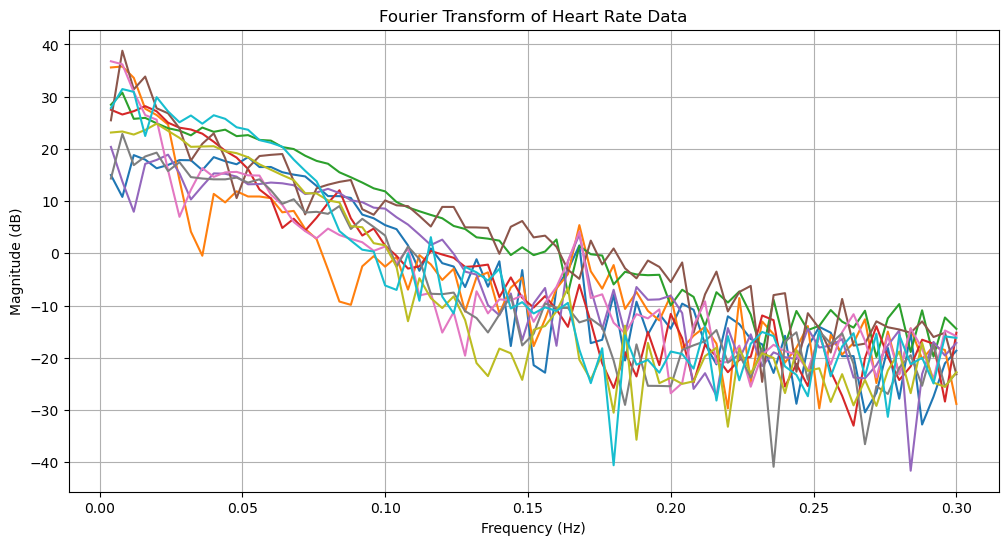

In [29]:
# Determine amount and plot some FFT training data samples
plt_cnt = 10
plt.figure(figsize=(12, 6))

for beat in fx_train_magsdb[:plt_cnt]:
    plt.plot(fx_train_freqs[0], beat)
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Heart Rate Data')
plt.grid()
plt.show()

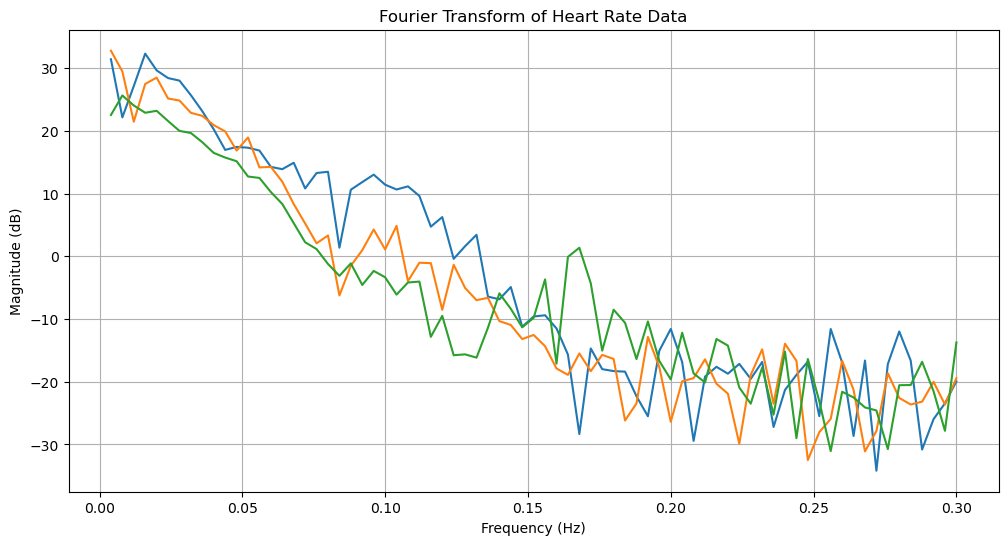

In [30]:
# Determine amount and plot some FFT validation data samples
plt_cnt = 3
plt.figure(figsize=(12, 6))

for beat in fx_val_magsdb[:plt_cnt]:
    plt.plot(fx_val_freqs[0], beat)
    
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Heart Rate Data')
plt.grid()
plt.show()

[0.35864236 0.50545503 0.56582242 0.60401587 0.63272411 0.64798101
 0.66140118 0.67197642 0.68201446 0.69181304 0.70107726 0.70988831
 0.71848733 0.72659351 0.73467642 0.74240815 0.74981354 0.75709299
 0.76427574 0.7713138 ]


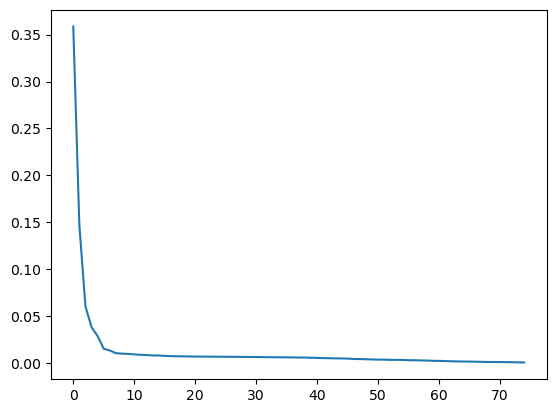

In [31]:
# apply PCA to the Fourier Data in dB
pca = PCA()
pca.fit(fx_train_magsdb)
X_train_pca = pca.transform(fx_train_magsdb)
X_val_pca = pca.transform(fx_val_magsdb)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

[0.65355762 0.80352238 0.87595167 0.9154574  0.94702503 0.96483238
 0.97478927 0.98081781 0.98469938 0.98807953 0.99016789 0.99170771
 0.99300511 0.99390535 0.99479048 0.99540649 0.99595542 0.99642048
 0.99681276 0.99718005]


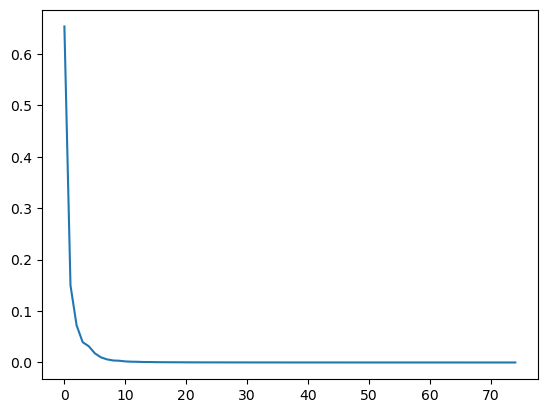

In [32]:
# apply PCA to the Fourier Data (non dB)
pca = PCA()
pca.fit(fx_train_mags)
X_train_pca = pca.transform(fx_train_mags)
X_val_pca = pca.transform(fx_val_mags)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

[0.65326157 0.80315087 0.87554787 0.91503343 0.94659759 0.96439574
 0.97434987 0.98039935 0.98428026 0.9877266  0.98983553 0.99141706
 0.99271531 0.99361515 0.99450394 0.99512124 0.99567323 0.99616643
 0.99656239 0.99693287]


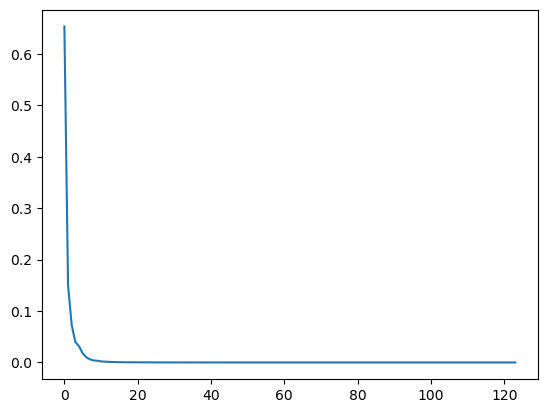

In [453]:
# apply PCA to the Fourier Data (non dB)
pca = PCA()
pca.fit(fx_train_mags)
X_train_pca = pca.transform(fx_train_mags)
X_val_pca = pca.transform(fx_val_mags)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

## Model Refinement (FFT)

In [454]:
len(fx_train_mags)

65670

In [41]:
clf_kn = KNeighborsClassifier(1)
clf_kn.fit(fx_train_mags, fy_train)
y_prediction_kn = clf_kn.predict(fx_val_mags)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn, average='macro')))

K Neighbours Classifier
Accuracy: 0.9756977753414645
F1 score: 0.7910643266242231
Recall score: 0.7654948025309606
Precision score: 0.849398157908204


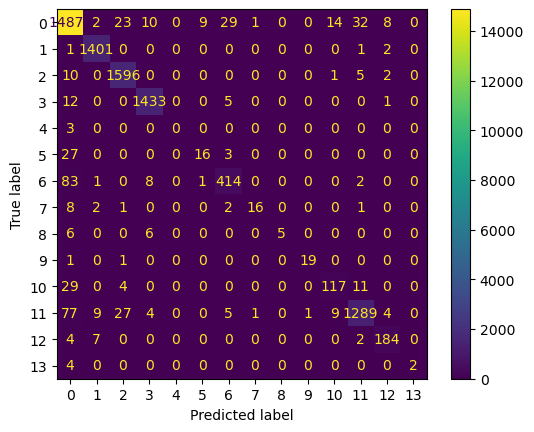

In [50]:
#Confusion matrix
c_matrix = confusion_matrix(fy_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [59]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100.fit(fx_train_mags, fy_train)
y_prediction_mlp_100 = clf_mlp_100.predict(fx_val_mags)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9716321776072359
F1 score: 0.7716305422819769
Recall score: 0.7565364698761436
Precision score: 0.7931043891948564


/Users/zacho/opt/anaconda3/envs/ML/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


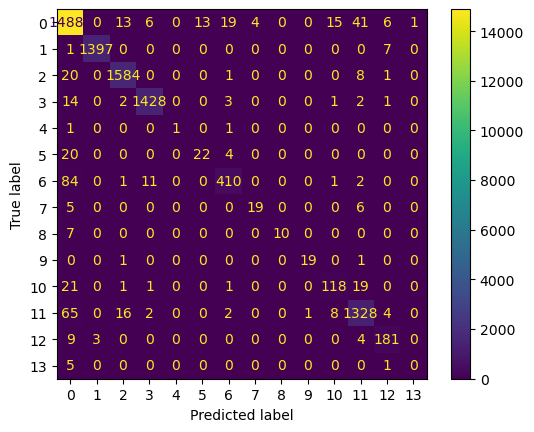

In [53]:
#Confusion matrix
c_matrix = confusion_matrix(fy_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

## Feature Design

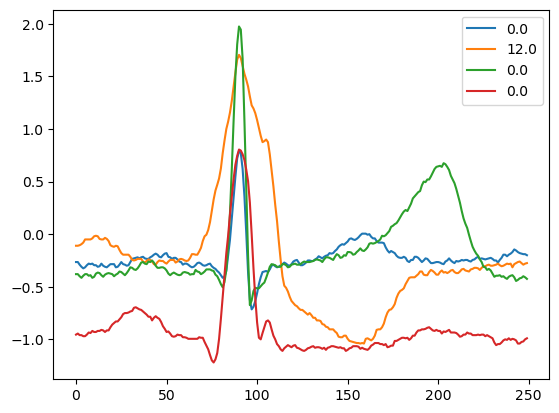

In [217]:
# plot the first few samples to visualize the data of X_train
for beat in X_train[:4]:
    plt.plot(beat)
plt.legend(y_train[:4])
plt.show()

In [186]:
#create a new feature that includes the derivatives in indices 250 to 498
X_train_with_der = np.concatenate((X_train, np.diff(X_train)),axis=1)
X_val_with_der = np.concatenate((X_val, np.diff(X_val)),axis=1)

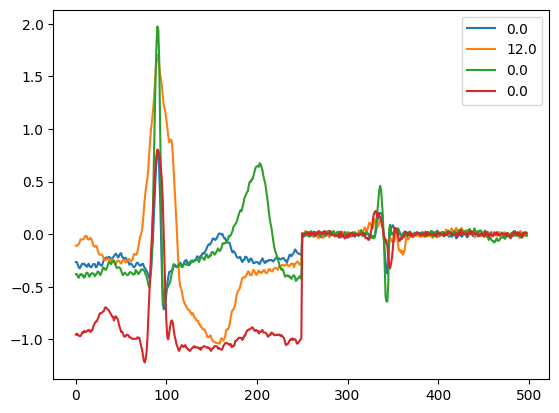

In [24]:
# plot the first few samples to visualize the data of X_train_with_der
for beat in X_train_with_der[:4]:
    plt.plot(beat)
plt.legend(y_train[:4])
plt.show()

[0.51747606 0.7102072  0.81619765 0.86865446 0.9047899  0.92423249
 0.93940956 0.95243933 0.96220591 0.96911134 0.97406081 0.97799619
 0.98164817 0.98426029 0.98658505 0.98856144 0.99000453 0.99127114
 0.99231174 0.9931061 ]


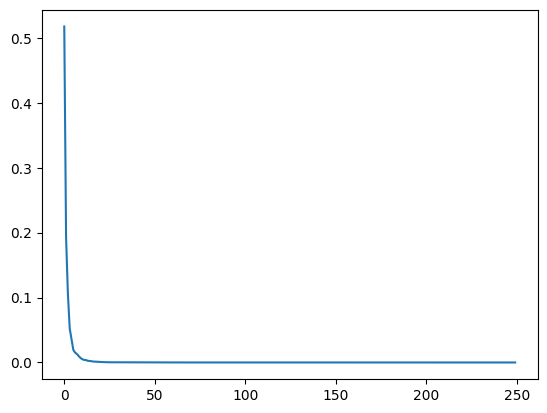

In [47]:
# apply PCA to the original data
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
print(np.cumsum(pca.explained_variance_ratio_[0:20]))
plt.plot(pca.explained_variance_ratio_)
plt.show()

## Model Refinement

In [27]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_prediction_lr = clf_lr.predict(X_val)
print("Logistic Regression Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_lr)))
print("F1 score: " + str(f1_score(y_val, y_prediction_lr, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_lr, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_lr, average='macro')))

Logistic Regression Classifier
Accuracy: 0.884792837239048
F1 score: 0.39475818390157397
Recall score: 0.366464318190779
Precision score: 0.45092742569264554


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


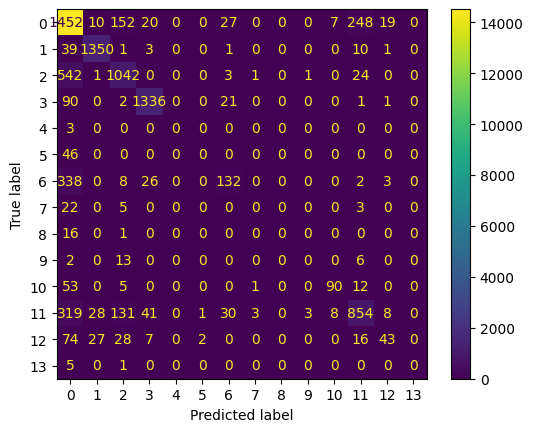

In [78]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_lr)
ConfusionMatrixDisplay(c_matrix).plot()

In [28]:
clf_kn = KNeighborsClassifier(3)
clf_kn.fit(X_train, y_train)
y_prediction_kn = clf_kn.predict(X_val)
print("K Neighbours Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_kn)))
print("F1 score: " + str(f1_score(y_val, y_prediction_kn, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_kn, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_kn, average='macro')))

K Neighbours Classifier
Accuracy: 0.9801288200630396
F1 score: 0.7100244643034197
Recall score: 0.6738495998324711
Precision score: 0.8017609243151551


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


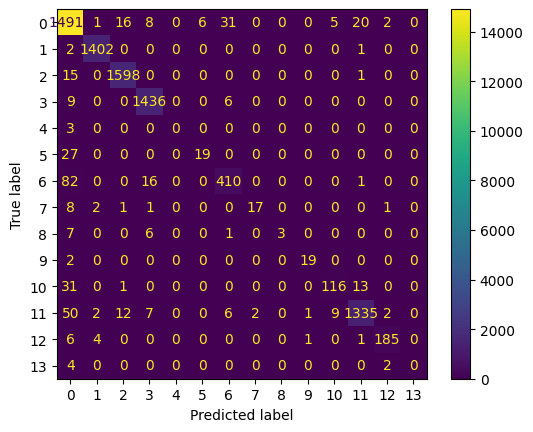

In [87]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_kn)
ConfusionMatrixDisplay(c_matrix).plot()

In [29]:
clf_mlp_100 = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100.fit(X_train, y_train)
y_prediction_mlp_100 = clf_mlp_100.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100, average='macro')))

MLP Classifier
Accuracy: 0.9854734822529807
F1 score: 0.8043240258679327
Recall score: 0.779284949992286
Precision score: 0.8352106794877597


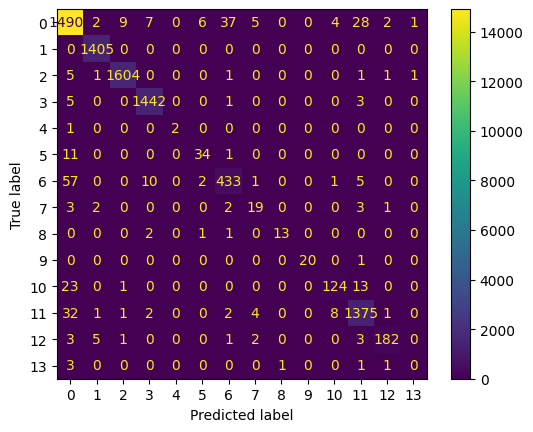

In [90]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_mlp_100)
ConfusionMatrixDisplay(c_matrix).plot()

In [30]:
clf_mlp_50_50_50 = MLPClassifier(hidden_layer_sizes=(50,50,50))
clf_mlp_50_50_50.fit(X_train, y_train)
y_prediction_mlp_50_50_50 = clf_mlp_50_50_50.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_50_50_50)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_50_50_50, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_50_50_50, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_50_50_50, average='macro')))

MLP Classifier
Accuracy: 0.9839203325567585
F1 score: 0.7671869978890626
Recall score: 0.7549398726321896
Precision score: 0.7991022652797071


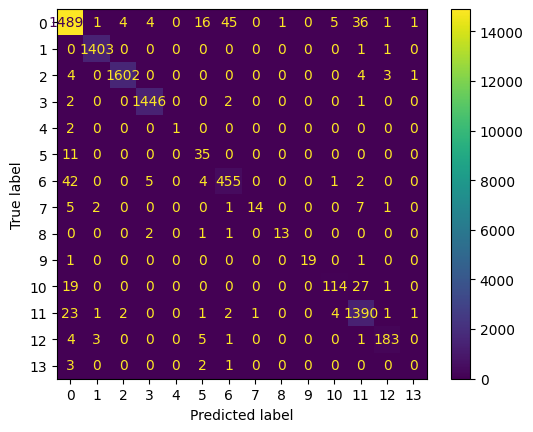

In [93]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_mlp_50_50_50)
ConfusionMatrixDisplay(c_matrix).plot()

In [31]:
clf_mlp_100_100_100_100 = MLPClassifier(hidden_layer_sizes=(100,100,100,100))
clf_mlp_100_100_100_100.fit(X_train, y_train)
y_prediction_100_100_100_100 = clf_mlp_100_100_100_100.predict(X_val)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_100_100_100_100)))
print("F1 score: " + str(f1_score(y_val, y_prediction_100_100_100_100, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_100_100_100_100, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_100_100_100_100, average='macro')))

MLP Classifier
Accuracy: 0.9853364396327258
F1 score: 0.7812722102695862
Recall score: 0.73225319189104
Precision score: 0.87796401151773


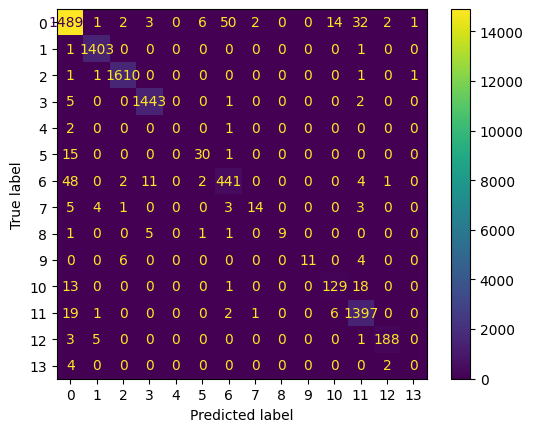

In [95]:
#Confusion matrix
c_matrix = confusion_matrix(y_val, y_prediction_100_100_100_100)
ConfusionMatrixDisplay(c_matrix).plot()

In [48]:
clf_mlp_100_pca = MLPClassifier(hidden_layer_sizes=(100))
clf_mlp_100_pca.fit(X_train_pca, y_train)
y_prediction_mlp_100_pca = clf_mlp_100_pca.predict(X_val_pca)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_pca)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_pca, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_pca, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_pca, average='macro')))

MLP Classifier
Accuracy: 0.9830980768352291
F1 score: 0.7596746533044458
Recall score: 0.7499128017312529
Precision score: 0.7752750376474582


c:\Users\Kirg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
clf_mlp_100_der = MLPClassifier(hidden_layer_sizes=(100,100,100,100))
clf_mlp_100_der.fit(X_train_with_der, y_train)
y_prediction_mlp_100_der = clf_mlp_100_der.predict(X_val_with_der)
print("MLP Classifier")
print("Accuracy: " + str(accuracy_score(y_val, y_prediction_mlp_100_der)))
print("F1 score: " + str(f1_score(y_val, y_prediction_mlp_100_der, average='macro')))
print("Recall score: " + str(recall_score(y_val, y_prediction_mlp_100_der, average='macro')))
print("Precision score: " + str(precision_score(y_val, y_prediction_mlp_100_der, average='macro')))

MLP Classifier
Accuracy: 0.9846512265314513
F1 score: 0.7718671118166928
Recall score: 0.7263449804154385
Precision score: 0.873395261894956
